In [1]:
import os

# Graphics
import matplotlib.pyplot as plt
import seaborn
from pysal.viz import splot
from splot.esda import plot_moran
import contextily

# Analysis
import geopandas as gpd
import pandas as pd
from pysal.explore import esda
from pysal.lib import weights
from numpy.random import seed

c:\Users\Masat\Anaconda3\envs\my-stan\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
# Global variables
BASE_DIR = r"data/brexit"
BREXIT_CSV_PATH = os.path.join(BASE_DIR, r"brexit_vote.csv")
BREXIT_SHP_PATH = os.path.join(BASE_DIR, r"local_authority_districts.geojson")
TARGET_COL = "Pct_Leave"


In [3]:
df_brexit = pd.read_csv(BREXIT_CSV_PATH, index_col="Area_Code")
# df_brexit.info()

gdf_brexit = gpd.read_file(BREXIT_SHP_PATH)
gdf_brexit = gdf_brexit.set_index("lad16cd")
# gdf_brexit.info()

# gdfに投票のデータを結合する
gdf_brexit = gpd.GeoDataFrame(gdf_brexit.join(df_brexit[TARGET_COL]), crs=gdf_brexit.crs)
gdf_brexit = gdf_brexit.to_crs(epsg=3857)
gdf_brexit = gdf_brexit[["objectid", "lad16nm", TARGET_COL, "geometry"]]
gdf_brexit.dropna(inplace=True)

gdf_brexit.info()

del df_brexit

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 22.9+ KB


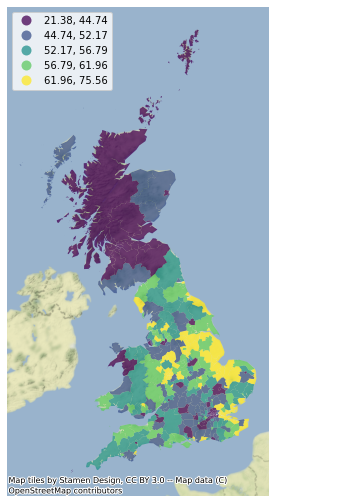

In [7]:
# Choropleth図を描画
# 最終的なプロットを読みやすくするために、いくつかの視覚的な調整（アルファ属性による透明化など）を行っていることに注目
f, ax = plt.subplots(1, figsize=(9, 9))
gdf_brexit.plot(
    column=TARGET_COL,
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds={"loc": 2},
    ax=ax,
)
# basemapを追加
contextily.add_basemap(
    ax,
    crs=gdf_brexit.crs,
    source=contextily.providers.Stamen.TerrainBackground,
)
ax.set_axis_off()

In [8]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(gdf_brexit, k=8)
# Row-standardization
w.transform = "R"

# Motivating Local Spatial Autocorrelation

In [9]:
# Calcurate Spatial Lag
gdf_brexit[TARGET_COL + "_lag"] = weights.spatial_lag.lag_spatial(
    w, gdf_brexit[TARGET_COL]
)
gdf_brexit.head()

,objectid,lad16nm,Pct_Leave,geometry,Pct_Leave_std,Pct_Leave_lag
lad16cd,,,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537...",16.429237,60.92125
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426...",12.339237,61.02625
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260...",13.049237,60.65125
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537...",8.589237,60.84375
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368...",14.479237,60.46750


In [10]:
gdf_brexit[TARGET_COL + "_std"] = gdf_brexit[TARGET_COL] - gdf_brexit[TARGET_COL].mean()
gdf_brexit[TARGET_COL+"_lag_std"] = gdf_brexit[TARGET_COL + "_lag"] - gdf_brexit[TARGET_COL+"_lag"].mean()

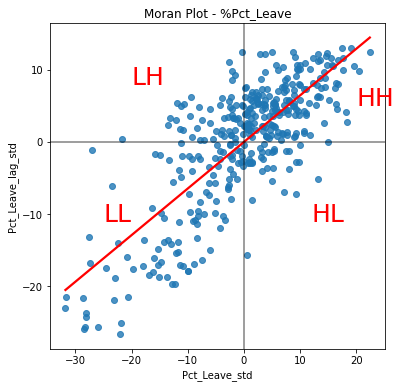

In [11]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x=TARGET_COL+"_std",
    y=TARGET_COL+"_lag_std",
    ci=None,
    data=gdf_brexit,
    line_kws={"color": "r"},
)
# Add vertical and horizontal lines
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title(f"Moran Plot - %{TARGET_COL}")
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

# Local Moran's I_i

In [12]:
# Create Local Moran's I object and calcurate
lisa = esda.moran.Moran_Local(gdf_brexit[TARGET_COL], w)

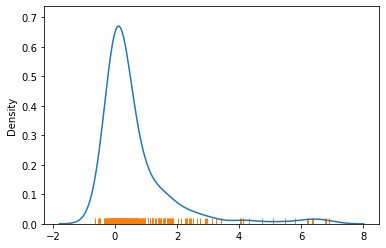

In [13]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

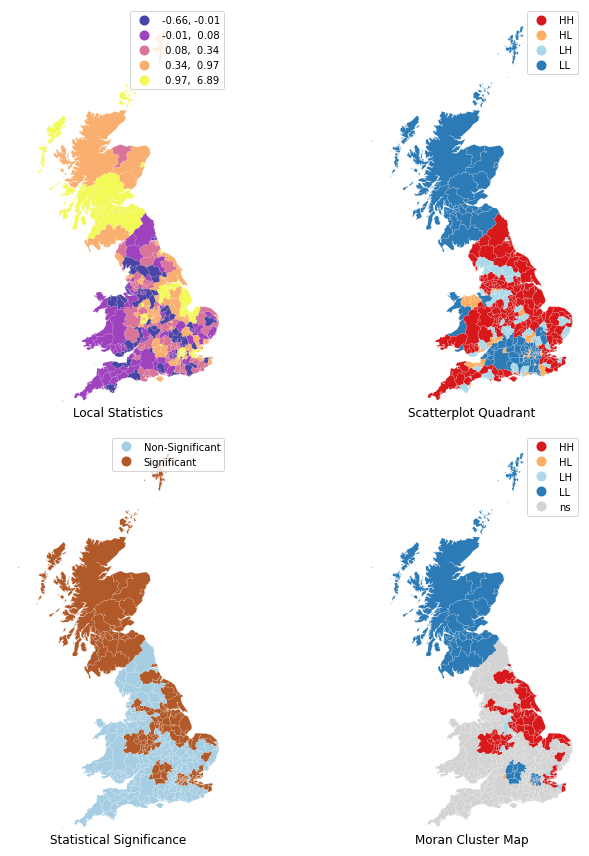

In [15]:
from splot import esda as esdaplot

# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf_brexit.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf_brexit, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=gdf_brexit.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
gdf_brexit.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf_brexit, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

In [19]:
# 各Observationが、Moran Plot内で第i象限に属しているかを占めす添字
from itertools import count


print(len(lisa.q))
print(lisa.q[:10])

# obtain counts of areas in each quadrant
counts = pd.value_counts(lisa.q)
counts

380
[1 1 1 1 1 1 4 1 4 1]


1    183
3    113
2     50
4     34
dtype: int64

In [20]:
# 380箇所のObservationのうち、Local Moran's Iが統計的に有意なのは...
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)
# Choropleth図からも、純粋な偶然という考えを否定できるほど強い局所的な空間的関連性を持つポリゴンが半分以下であることが分かる。

42.36842105263158

In [21]:
# Assign pseudo P-values to `df`
gdf_brexit["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
gdf_brexit["sig"] = sig
# Print top of the table to inspect
gdf_brexit[["sig", "p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.006
E06000002,1,0.006
E06000003,1,0.009
E06000004,1,0.006
E06000010,1,0.009


In [22]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
gdf_brexit["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=gdf_brexit.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
gdf_brexit["labels"].head()

lad16cd
E06000001    HH
E06000002    HH
E06000003    HH
E06000004    HH
E06000010    HH
Name: labels, dtype: object

In [23]:
# これらの新しい列を構築した後、LISA統計の全体的な傾向に関する分析は、lisaオブジェクトから行うよりもより簡単である。例えば、ラベルの分布の概要が1行でわかります。
gdf_brexit["labels"].value_counts()

Non-Significant    219
HH                  79
LL                  70
LH                   8
HL                   4
Name: labels, dtype: int64